In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from IPython.display import Image, display
import io

In [98]:
def get_random_entry(filename):
    return random.choice(open(filename).readlines()).replace("\n", "")

In [99]:
class Strategy:

    def __init__(self, talent):
        self.days = 250
        self.name = self.generate_name()
        self.daily_expected_trades = np.random.exponential(4)
        self.exponent = np.random.poisson(2)
        self.daily_stdev = max(0, np.random.normal(10, 3))
        self.mean = np.random.normal(talent, 2)
        self.size_factor = np.random.uniform(0, 1)

    def generate_name(self):
        provenance = get_random_entry("data/products/provenance.txt")
        product = get_random_entry("data/products/product.txt").lower()
        return f"{provenance} {product}"

    def generate_annual_daily_pnl(self):
        daily_size = np.random.poisson(
            self.daily_expected_trades,
            self.days
        ) ** self.exponent
        daily_size = self.size_factor * daily_size / daily_size.mean()
        daily_pnl = pd.Series(
            daily_size * np.random.normal(
                self.mean,
                self.daily_stdev,
                self.days
            ),
            index=np.arange(self.days)
        )
        return daily_pnl

    def generate_reported_pnl(self, deceptiveness):
        annual_pnls = [
            self.generate_annual_daily_pnl()
            for i in range(np.random.geometric(1 / deceptiveness))
        ]
        reported_pnl = sorted([[annual_pnl.sum(), annual_pnl] for annual_pnl in annual_pnls])[-1][1]
        return reported_pnl

In [257]:
class Analyst:

    def __init__(self):
        """
        Special note: history is a list of triples:
        [strategy_name, reported_pnl, actual_pnl]
        If the strat wasn't chosen, actual_pnl is None
        """
        self.name = self.generate_name()
        self.deceptive = np.random.geometric(1/3)
        self.talented = np.random.normal(0.5, 1)
        self.current_strategy = None
        self.salary = 50
        self.history = []

    def generate_name(self):
        gender = random.choice(["Male", "Female"])
        # Not a political statement, just how Roman names work
        suffix = "us" if gender == "Male" else "a"
        praenomen = get_random_entry("data/name/praenomen.txt") + suffix
        nomen = get_random_entry("data/name/nomen.txt")
        if gender == "Female": 
            nomen = nomen[:-2] + "a"
        cognomen = get_random_entry(f"data/name/{gender.lower()}_cognomen.txt")
        return f"{praenomen} {nomen} {cognomen}"

    def generate_strategy(self):
        self.current_strategy = Strategy(self.talented)

    def report_strategy(self):
        reported = self.current_strategy.generate_reported_pnl(self.deceptive)
        self.history.append([self.current_strategy.name, reported.sum(), None])
        return reported

    def run_strategy(self):
        actual = self.current_strategy.generate_annual_daily_pnl()
        self.salary += 50
        self.history[-1][2] = actual.sum()
        return actual

    def report_history(self):
        print(f"\t{self.name}'s history:")
        for item in self.history:
            if item[2] is None:
                print(f"\t\t{item[0]}. Reported: {item[1]:+.2f}, not implemented")
            else:
                print(f"\t\t{item[0]}. Reported: {item[1]:+.2f}, actual: {item[2]:+.2f}")

    def print_stats(self):
        print(f"\t{self.name}'s history:")
        print(f"\t\tTalented: {self.talented:.2f}")
        print(f"\t\tDeceptive: {self.deceptive:.2f}")

In [269]:
class Pod:

    def __init__(self, num_analysts):
        self.analysts = [Analyst() for _ in range(num_analysts)]
        self.fired_analysts = []
        self.aum = 1000
        self.name = get_random_entry("data/firm_name/name.txt")
        print(f"The firm {self.name} has just been opened")
        print(f"Assets under management: {self.aum}s")
        names = '\n\t'.join([analyst.name for analyst in self.analysts])
        print(f"Current staff are:\n\t{names}")

    def display_graph_as_png(self, fig):
        buffer = io.BytesIO()
        plt.tight_layout()
        fig.savefig(buffer, format='png')
        buffer.seek(0)
        display(Image(buffer.read()))
        plt.close(fig)

    def show_history(self):
        """
        For each analyst, pulls up their history of coming up with strats
        """
        for analyst in self.analysts:
            analyst.report_history()

    def get_multi_choice(self, options):
        for i, option in zip(range(1, len(options) + 1), options):
            print(f"({i}) {option}")
        print("Type in your choice:")
        while True:
            player_choice = input()
            if player_choice == "HISTORY":
                self.show_history()
                continue
            try:
                choice_num = int(player_choice)
                if choice_num > len(options) or choice_num <= 0:
                    print("Invalid number, try again")
                    continue
                return choice_num
            except ValueError:
                print("That's not a number, try again")

    def get_strategy_choice(self):
        """
        Returns one of three options:
            1. Play it safe and go for imperial debt
            2. Irresponsibly put on a single huge bet at the chariots
            3. Choose a given analyst's strategy
        Note in case (3) it returns an Analyst, not a Strategy
        """
        # Generate and display strategies
        for analyst in self.analysts:
            analyst.generate_strategy()
        if len(self.analysts) > 0:
            fig, ax = plt.subplots(
                nrows=1, 
                ncols=len(self.analysts),
                figsize=(len(self.analysts) * 3, 3),
                sharex=True,
                sharey=True
            )
            for i, analyst in zip(range(len(self.analysts)), self.analysts):
                cumulative_reported = analyst.report_strategy().cumsum()
                if len(self.analysts) > 1:
                    ax[i].plot(cumulative_reported, color="black")
                else:
                    ax.plot(cumulative_reported, color="black")
                title = "\n".join([
                    analyst.name, 
                    analyst.current_strategy.name, 
                    f"{cumulative_reported.iloc[-1]:.2f}s"
                ])
                if len(self.analysts) > 1:
                    ax[i].set_title(title)
                else:
                    ax.set_title(title)
            self.display_graph_as_png(fig)
        treasury_rate = random.choice([1, 2, 3, 4, 5])
        chariot_odds = 1 + np.random.binomial(8, 0.25)
        strategy_names = [
            f"Imperial bonds ({treasury_rate}%)",
            f"Punt on Blue at the chariots ({chariot_odds}:1 odds)"
        ]
        # Get player choice of strategies
        strategy_names += [
            f"{analyst.name}'s {analyst.current_strategy.name} trade"
            for analyst in self.analysts
        ]
        choice = self.get_multi_choice(strategy_names)
        print("How much will you stake?")
        print(f"NOTE: cannot be more than current AUM, {self.aum:.2f}s")
        while True:
            input_stake = input()
            try:
                stake = float(input_stake)
                if stake > self.aum or stake < 0:
                    print("Invalid number, try again")
                    continue
                break
            except ValueError:
                print("That's not a number, try again")
        if choice == 1:
            return [f"IMPERIAL BONDS {treasury_rate}", stake]
        elif choice == 2:
            return [f"CHARIOT PUNT {chariot_odds}", stake]
        else:
            return [self.analysts[choice - 3], stake]

    def process_annual_finances(self, strat_choice):
        """
        Gets returns from investments, updates AUM, and pays employees
        Args is strat_choice, which is [strategy, stake] list
        """
        # Get strat pnl, add to the total
        strat, stake = strat_choice[0], strat_choice[1]
        old_salaries = [analyst.salary for analyst in self.analysts]
        old_aum = self.aum
        new_aum = old_aum - strat_choice[1]
        if type(strat) == str:
            if strat[:-2] == "IMPERIAL BONDS":
                treasury_rate = int(strat[-1])
                interest = stake * (1 + treasury_rate / 100)
                print(f"Interest accumulated: {interest - stake:.2f}s")
                new_aum += interest
            else:
                chariot_odds = int(strat[-1]) + 1
                chariot_wins = random.random() < 0.25
                if chariot_wins:
                    print("Blue chariot wins!")
                    winnings = stake * chariot_wins * chariot_odds
                    print(f"Winnings: {winnings - stake:.2f}s")
                    new_aum += winnings
                else: 
                    print("Blue chariot does NOT win")
        else:
            chosen_analyst = strat
            actual_result = chosen_analyst.run_strategy()
            fig, ax = plt.subplots(figsize=(4, 4))
            ax.plot(actual_result.cumsum(), color="black")
            title = "\n".join([
                chosen_analyst.name,
                chosen_analyst.current_strategy.name,
                "Actual result"
            ])
            ax.set_title(title)
            self.display_graph_as_png(fig)
            returns = stake * (1 + actual_result.sum() / 1000)
            print(f"Return on investment: {returns - stake:.2f}s")
            new_aum += returns
        self.aum = new_aum
        print(f"AUM after investments: {self.aum:.2f}s")
        # Now pay salaries and update new wages
        salary_bill = sum(old_salaries)
        print(f"Paid out {salary_bill:.2f}s in salaries")
        self.aum -= salary_bill
        print(f"Current AUM: {self.aum:.2f}s")

    def fire_analysts(self):
        while len(self.analysts) > 0:
            print("Fire employees?")
            options = ["No firing"] + [analyst.name for analyst in self.analysts]
            choice = self.get_multi_choice(options)
            if choice == 1:
                break
            else:
                fired_analyst = self.analysts[choice - 2]
                self.analysts.remove(fired_analyst)
                self.fired_analysts.append(fired_analyst)
                print('> "' + get_random_entry(
                        "data/fire_message/youre_fired.txt"
                    ).replace("NAME", fired_analyst.name)+ '"'
                )
                print(
                    '> "' + get_random_entry(
                        "data/fire_message/response.txt"
                    ) + '"'
                )
                print(get_random_entry("data/fire_message/zoom_out.txt"))

    def hire_analysts(self):
        print("How many analysts to hire?")
        while True:
            player_input = input()
            try:
                choice = int(player_input)
                if choice < 0:
                    print("You can't hire negative analysts")
                    continue
                break
            except ValueError:
                print("That's not an integer - try again")
        new_analysts = [Analyst() for _ in range(choice)]
        self.analysts += new_analysts
        if len(new_analysts) > 0:
            names = '\n\t'.join([analyst.name for analyst in new_analysts])
            print(f"Welcome to the team:\n\t{names}")

    def run_one_year(self):
        strat_choice = self.get_strategy_choice()
        self.process_annual_finances(strat_choice)
        if self.aum <= 0:
            print("Oh no! You ran out of money!")
            return True
        self.fire_analysts()
        self.hire_analysts()
        return False

    def print_end_data(self):
        print("GAME OVER")
        print(f"Final PNL: {self.aum - 1000:.2f}s")
        print("Current analyst stats")
        for analyst in self.analysts:
            analyst.print_stats()
        print("Fired analyst stats")
        for analyst in self.fired_analysts:
            analyst.print_stats()
        print("You spend whatever sesterces you gained.")
        print("Life goes on, for better or worse you cannot say.")
        print("Soon your name is forgotten.")

    def run_multi_years(self, num_years):
        for year in range(num_years):
            over = self.run_one_year()
            if over:
                break
        self.print_end_data()

The firm Condimer has just been opened
Assets under management: 1000s
Current staff are:
	Publius Flaminius Curio
	Lucia Mucia Metella
	Gnaeus Baebius Geminianus


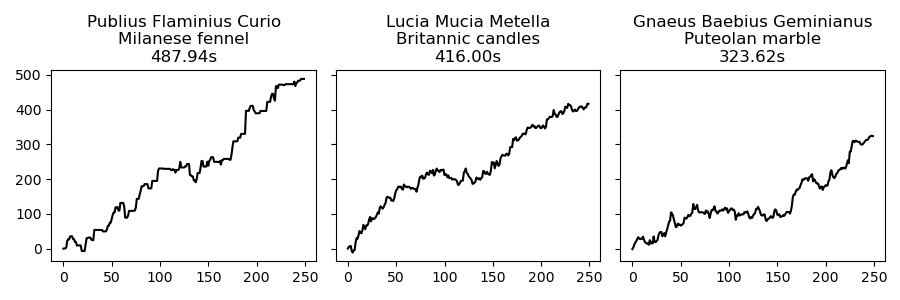

(1) Imperial bonds (2%)
(2) Punt on Blue at the chariots (3:1 odds)
(3) Publius Flaminius Curio's Milanese fennel trade
(4) Lucia Mucia Metella's Britannic candles trade
(5) Gnaeus Baebius Geminianus's Puteolan marble trade
Type in your choice:


 3


How much will you stake?
NOTE: cannot be more than current AUM, 1000.00s


 700


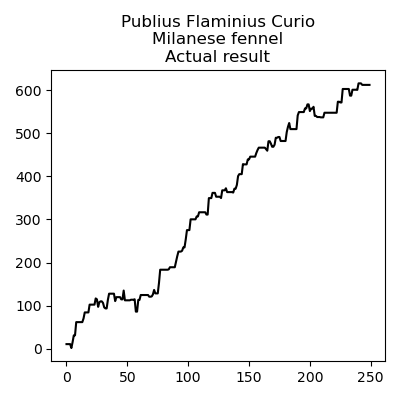

Return on investment: 428.54s
AUM after investments: 1428.54s
Paid out 150.00s in salaries
Current AUM: 1278.54s
Fire employees?
(1) No firing
(2) Publius Flaminius Curio
(3) Lucia Mucia Metella
(4) Gnaeus Baebius Geminianus
Type in your choice:


 HISTORY


	Publius Flaminius Curio's history:
		Milanese fennel. Reported: +487.94, actual: +612.20
	Lucia Mucia Metella's history:
		Britannic candles. Reported: +416.00, not implemented
	Gnaeus Baebius Geminianus's history:
		Puteolan marble. Reported: +323.62, not implemented


 4


> "Gnaeus Baebius Geminianus, I must do the inevitable."
> "Stir not the bitter cup I mixed for myself."
The stars set over the sea. 
Fire employees?
(1) No firing
(2) Publius Flaminius Curio
(3) Lucia Mucia Metella
Type in your choice:


 1


How many analysts to hire?


 2


Welcome to the team:
	Julia Maccia Aventina
	Sexta Fausta Livigena


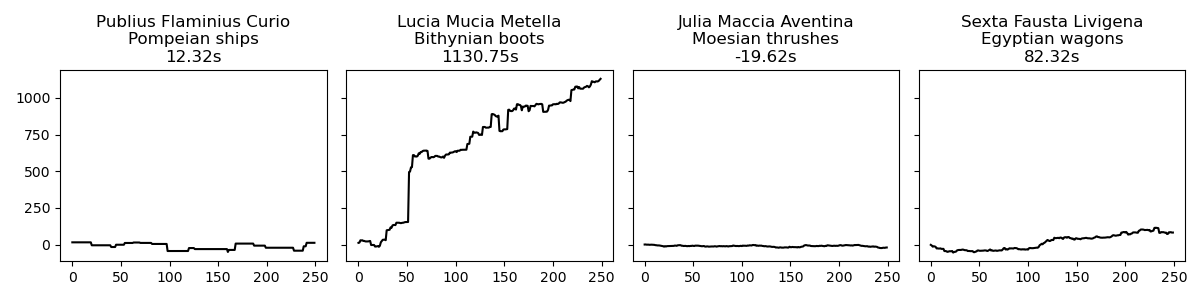

(1) Imperial bonds (4%)
(2) Punt on Blue at the chariots (4:1 odds)
(3) Publius Flaminius Curio's Pompeian ships trade
(4) Lucia Mucia Metella's Bithynian boots trade
(5) Julia Maccia Aventina's Moesian thrushes trade
(6) Sexta Fausta Livigena's Egyptian wagons trade
Type in your choice:


 2


How much will you stake?
NOTE: cannot be more than current AUM, 1278.54s


 400


Blue chariot does NOT win
AUM after investments: 878.54s
Paid out 250.00s in salaries
Current AUM: 628.54s
Fire employees?
(1) No firing
(2) Publius Flaminius Curio
(3) Lucia Mucia Metella
(4) Julia Maccia Aventina
(5) Sexta Fausta Livigena
Type in your choice:


 4


> "Julia Maccia Aventina, your day has come."
> "Why do you bother combing your hair like that? Everyone can see you're balding."
Justice is done. 
Fire employees?
(1) No firing
(2) Publius Flaminius Curio
(3) Lucia Mucia Metella
(4) Sexta Fausta Livigena
Type in your choice:


 1


How many analysts to hire?


 0


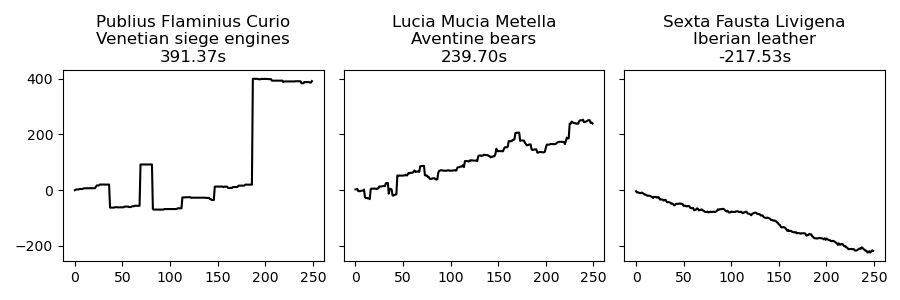

(1) Imperial bonds (4%)
(2) Punt on Blue at the chariots (3:1 odds)
(3) Publius Flaminius Curio's Venetian siege engines trade
(4) Lucia Mucia Metella's Aventine bears trade
(5) Sexta Fausta Livigena's Iberian leather trade
Type in your choice:


 4


How much will you stake?
NOTE: cannot be more than current AUM, 628.54s


 250


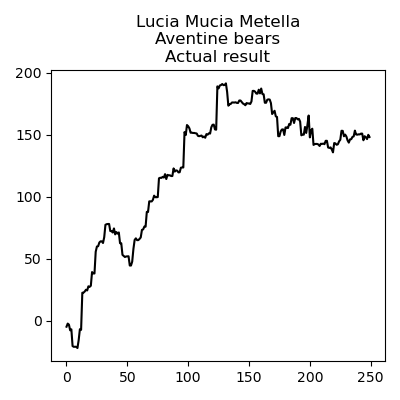

Return on investment: 37.08s
AUM after investments: 665.62s
Paid out 200.00s in salaries
Current AUM: 465.62s
Fire employees?
(1) No firing
(2) Publius Flaminius Curio
(3) Lucia Mucia Metella
(4) Sexta Fausta Livigena
Type in your choice:


 4


> "You bring shame to our company, Sexta Fausta Livigena."
> "A pox upon you all!"
You could never have endured them for long. 
Fire employees?
(1) No firing
(2) Publius Flaminius Curio
(3) Lucia Mucia Metella
Type in your choice:


 1


How many analysts to hire?


 0


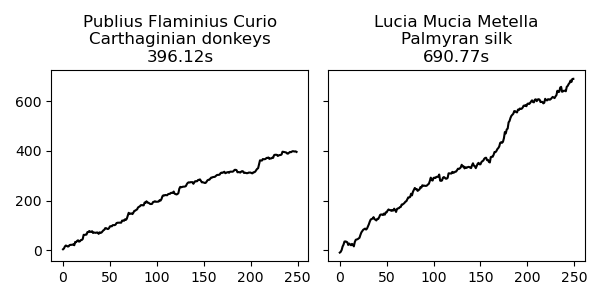

(1) Imperial bonds (2%)
(2) Punt on Blue at the chariots (2:1 odds)
(3) Publius Flaminius Curio's Carthaginian donkeys trade
(4) Lucia Mucia Metella's Palmyran silk trade
Type in your choice:


 4


How much will you stake?
NOTE: cannot be more than current AUM, 465.62s


 465


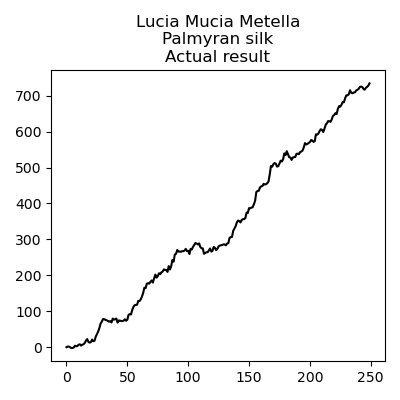

Return on investment: 341.19s
AUM after investments: 806.82s
Paid out 200.00s in salaries
Current AUM: 606.82s
Fire employees?
(1) No firing
(2) Publius Flaminius Curio
(3) Lucia Mucia Metella
Type in your choice:


 1


How many analysts to hire?


 0


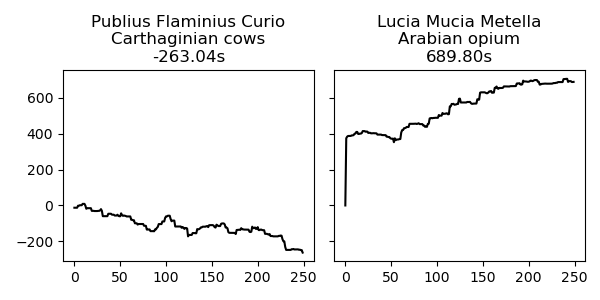

(1) Imperial bonds (3%)
(2) Punt on Blue at the chariots (1:1 odds)
(3) Publius Flaminius Curio's Carthaginian cows trade
(4) Lucia Mucia Metella's Arabian opium trade
Type in your choice:


 4


How much will you stake?
NOTE: cannot be more than current AUM, 606.82s


 606.82


Invalid number, try again


 606


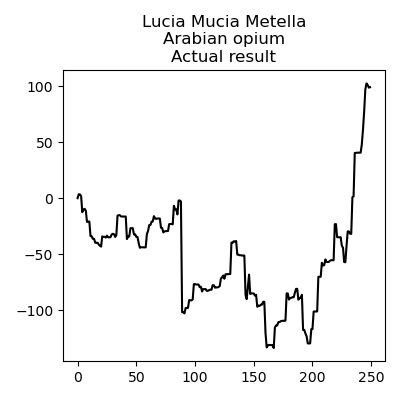

Return on investment: 60.03s
AUM after investments: 666.84s
Paid out 250.00s in salaries
Current AUM: 416.84s
Fire employees?
(1) No firing
(2) Publius Flaminius Curio
(3) Lucia Mucia Metella
Type in your choice:


 1


How many analysts to hire?


 0


GAME OVER
Final PNL: -583.16s
Current analyst stats
	Publius Flaminius Curio's history:
		Talented: -0.22
		Deceptive: 7.00
	Lucia Mucia Metella's history:
		Talented: 0.89
		Deceptive: 8.00
Fired analyst stats
	Gnaeus Baebius Geminianus's history:
		Talented: -0.24
		Deceptive: 1.00
	Julia Maccia Aventina's history:
		Talented: 0.22
		Deceptive: 2.00
	Sexta Fausta Livigena's history:
		Talented: 0.70
		Deceptive: 2.00
You spend whatever sesterces you gained.
Life goes on, for better or worse you cannot say.
Soon your name is forgotten.


In [268]:
# CONFIG
num_analysts = 3
num_years = 5

# Play the game
pod = Pod(num_analysts)
pod.run_multi_years(num_years)